This notebook contains a summary of all the work Sam Deverett did for Dieta.

# Problem Statement

## General

An estimated 25-45 million Americans suffer from irritable bowel syndrome (IBS). While a professional is able to diagnose patients with the intestinal disorder, the best current cure is to simply try a plethora of diets until finding one that alleviates the symptom. This takes tremendous effort and lots of time - without even guarenteeing a solution.

Dieta is a mobile and web applitcation that uses data science to accelerate the healing process for IBS patients. By analyzing data on a user's digestive health, including their food intake and bowel movements, Dieta is able to more effectively identify triggers and more personally recommend diets. Furthermore, by anonymously aggregating insights from many users, Dieta allows patients with similar symptoms to grow better both faster and more unified.

## Project Specific

This project focuses on finding insights across users. The goal is to be able to suggest users strategies to combat their symptoms based on the insights learned from patients just like them. For example, if it is known that a user belongs to a group of IBS patients with a certain subset of symtpoms and there is another patient in that group who has found a diet that works to alleviate those symptoms, Dieta would identify this and then suggest that diet to the original user. 

I will frame this problem as a clustering one. Clustering, a type of unsupervised machine learning, will allow me to detect groups of users. (This project will not include the recommender engine applied to the clustering insights.)

Performing clustering will involve the following steps:

* [setting up](#set_up) the environment
* [loading](#loading) the data
* [exploring](#EDA) the data
* [preprocessing](#preprocessing) the data
* [feature engineering](#feature_engineering) distinguishing characteristics of users
* selecting the [number of clusters](#num_clusters)
* running various [clustering](#clustering) algorithms
* [choosing](#choose) the best clustering

Although there is no "correct" way to cluster data, the merit of each clustering will be determined (roughly) by comparing the outputted clusters to medical research's best current model, namely subdiagnoses of IBS.
(### Would be great to have had the actual labels of the patients; then I could've had a true baseline clustering to "beat")

<a id='set_up'></a>

# Set Up

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<a id='loading'></a>

# Loading the Data

The data are collected from the Dieta mobile application. Users can input their foods, drinks, medications, symtpoms, bowel movements, exercise, sleep, and mood. 

<img src='inputs.png' style="width:200px;height:300px"></img>

In this project, I will only use data related to patients' symptoms and bowel movements. Thus, the clusters formed will only be functions of patients' symptoms and bowel movements. This means that a patient's personal details, like their triggers and medications, will *not* inform the clustering whatsoever.

The data for **bowel movements** look as follows:

In [2]:
bm_df = pd.read_csv('bms.csv', index_col='id')
bm_df.head()

,consistency,difficulty,pain,smell,completeness,urgency,duration,occurred_at,fake_user_id
id,,,,,,,,,
6162,40.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-04 19:10:00,480
6161,40.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-04 11:30:00,480
6131,50.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-03 14:05:00,480
6103,50.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-02 22:00:00,480
6102,50.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-02 14:00:00,480


In [3]:
print(f'There are {bm_df.shape[0]} rows and {bm_df.shape[1]} columns.')

There are 6015 rows and 9 columns.


The data for **symptoms** look as follows:

In [4]:
sym_df = pd.read_csv('syms.csv')
sym_df.head()

,occurred_at,symptom,intensity,duration,fake_user_id
0,2019-06-20 22:00:00,stomach pain,25,60,480
1,2019-06-20 22:00:00,urgency,40,60,480
2,2019-06-25 18:00:00,pain,15,0,480
3,2019-06-20 16:00:00,urgency,5,0,480
4,2019-06-20 12:00:00,urgency,40,0,480


In [5]:
print(f'There are {bm_df.shape[0]} rows and {bm_df.shape[1]} columns.')

There are 6015 rows and 9 columns.


<a id='EDA'></a>

# EDA

### Missing Values

The percent of missing values per attribute is as follows:

In [6]:
print('Bowel Movements:')
display(bm_df.isnull().sum() / len(bm_df) * 100)

print('Symptoms:')
display(sym_df.isnull().sum() / len(sym_df) * 100)

Bowel Movements:


consistency      1.213633
difficulty      49.609310
pain            70.656692
smell           66.932668
completeness    41.463009
urgency         55.627598
duration         0.000000
occurred_at      0.000000
fake_user_id     0.000000
dtype: float64

Symptoms:


occurred_at     0.0
symptom         0.0
intensity       0.0
duration        0.0
fake_user_id    0.0
dtype: float64

These percents are slightly misleading, because the attribute "duration" has a preset value of 0. Here is a more accurate metric of missing "duration" values:

In [7]:
print('Bowel Movements:')
display(len(bm_df[bm_df['duration'] == 0]) / len(bm_df))

print('Symptoms:')
display(len(sym_df[sym_df['duration'] == 0]) / len(sym_df))

Bowel Movements:


0.8513715710723192

Symptoms:


0.7907623017584208

Where do these missing values come from? How are they distributed among users?

In [103]:
def get_user_null_values(df):
    user_null_values = {}
    for user_id in df['fake_user_id'].unique():
        user_df = df[df['fake_user_id'] == user_id]
        null_proportions = user_df.isnull().sum() / len(user_df)
        user_null_values[user_id] = null_proportions
    return user_null_values

def proportion_of_null_per_user(df, feature):
    null_proportions = {}
    user_null_values = get_user_null_values(df)
    for key in user_null_values:
        null_proportion = user_null_values[key][feature]
        null_proportions[key] = null_proportion
    return null_proportions

def plot_null_proportions_per_user(df, feature):
    dic = proportion_of_null_per_user(df, feature)
    proportions = list(dic.values())
    mean, median = np.mean(proportions), np.median(proportions)
#     plt.figure(figsize=(10,4))
    plt.hist(proportions, range=[0, 1])
    plt.vlines(mean, 0, 100, 'red', 'dashed', 'mean')
    plt.vlines(median, 0, 100, 'green', 'dashed', 'median')
    plt.legend()
    plt.title(f'proportion of null {feature} values per user');

Bowel Movements:


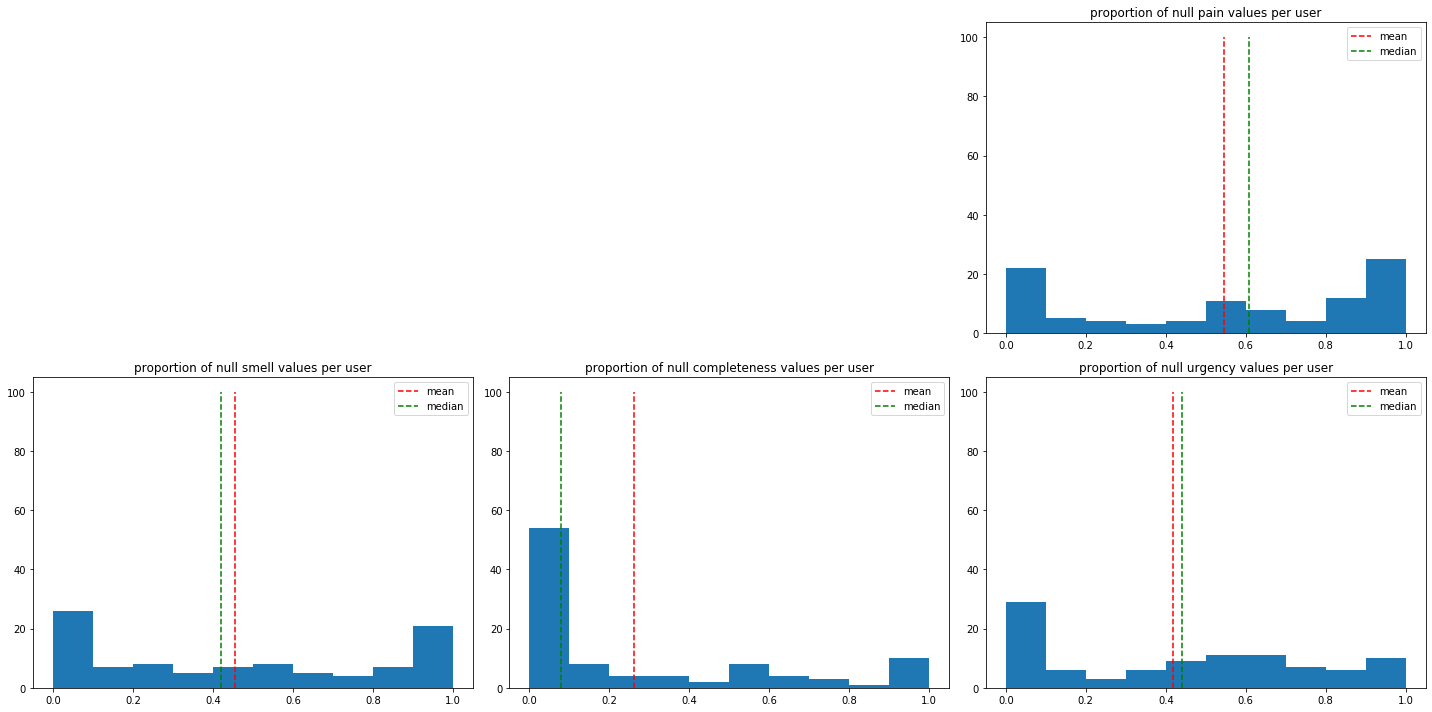

In [106]:
print('Bowel Movements:')
bm_features = ['consistency', 'difficulty', 'pain', 'smell', 'completeness', 'urgency']
plt.figure(figsize=(20,10))
i, j = 1, 1
for feature in bm_features:
    plt.subplot(j, 3, i)
    plot_null_proportions_per_user(bm_df, feature)
    i += 1
    if i == 3:
        j += 1
plt.tight_layout();

### Imputation

As shown above, many attributes have a significant percent of missing values. I considered two options for dealing with this:

**1)** Dropping data points with missing values.

**2)** Imputing values for attributes based on that attribute's values in other data points from the *same* user. (I did *not* consider imputing values based on data points from all other users, because this would make each user more similar, making clustering both harder and less effective.)

To quantify the value of imputation, I ran two simple 3-dimensional clusterings, first on data without imputations and then on data with them. The effect of imputating missing values turned out to be negligable: the centers of clusters, distances between clusters, and the makeup of clusters remained nearly constant. This is likely because imputing values, using their mean or median imputation, did not change the makeup of any one user; it simply gave each user more of their same data. Such magnification, however, does not affect clustering.

Furthermore, I was encouraged to avoid imputation because of the sheer quantity of missing values. Many features are missing upwards of 50%! It is not statistically sound to impute values for such a large portion of the data.

Thus, I will drop any data with missing values.

### Attribute Distributions

In [26]:
def plot_feature_distribution(df, feature):
    plt.figure(figsize=(20,10))
    plt.hist(list(bm_df[feature]), range=[0, 100])
    plt.title(f'{feature} distribution');

Bowel Movements:


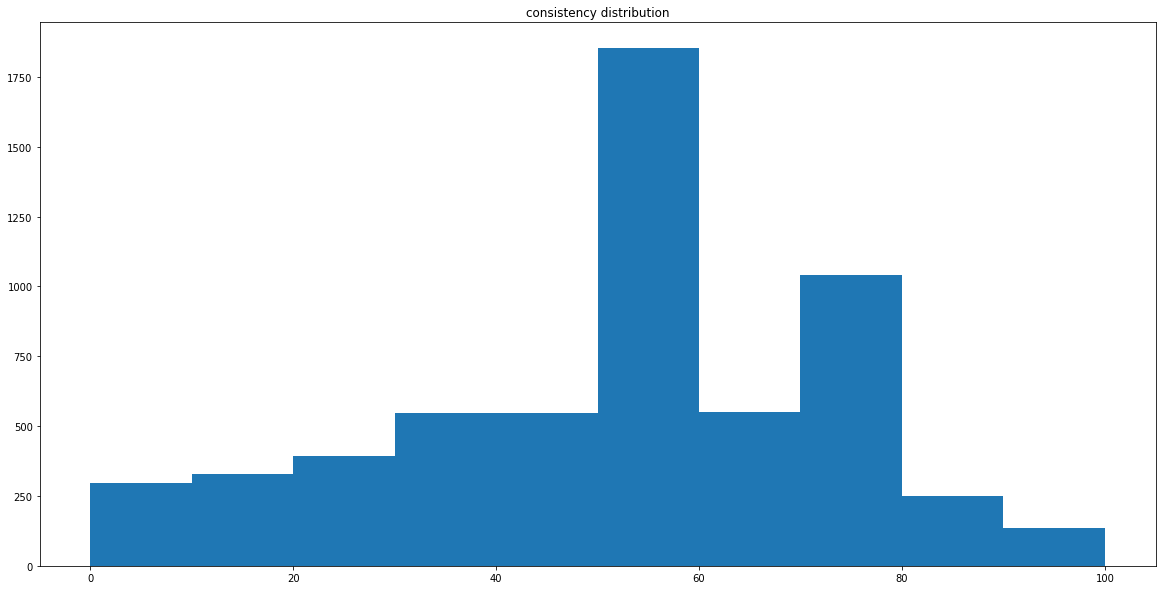

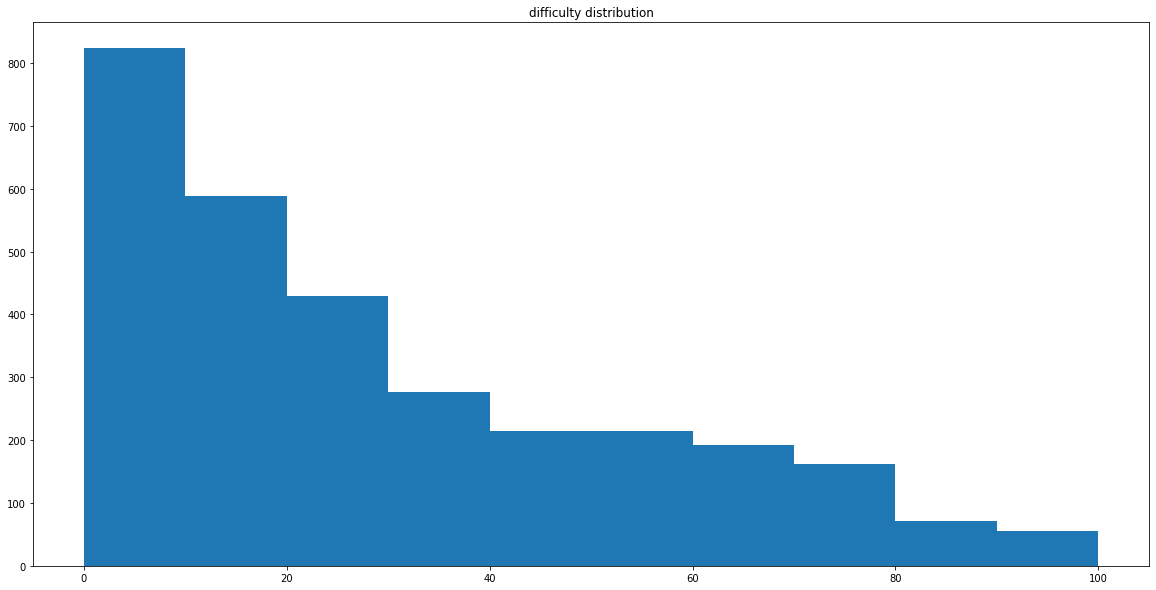

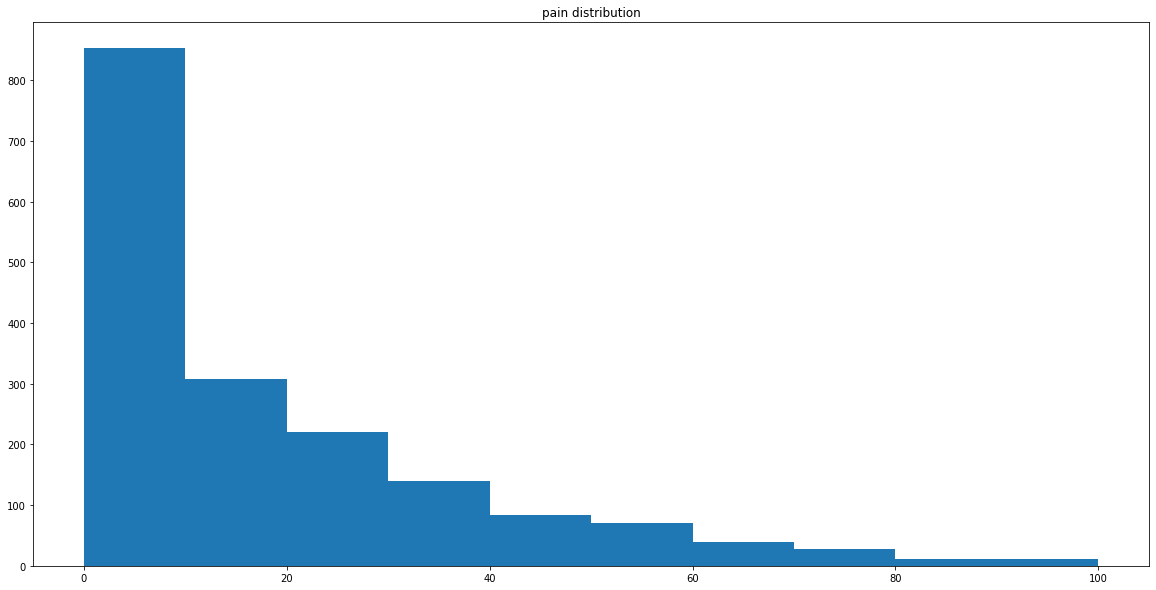

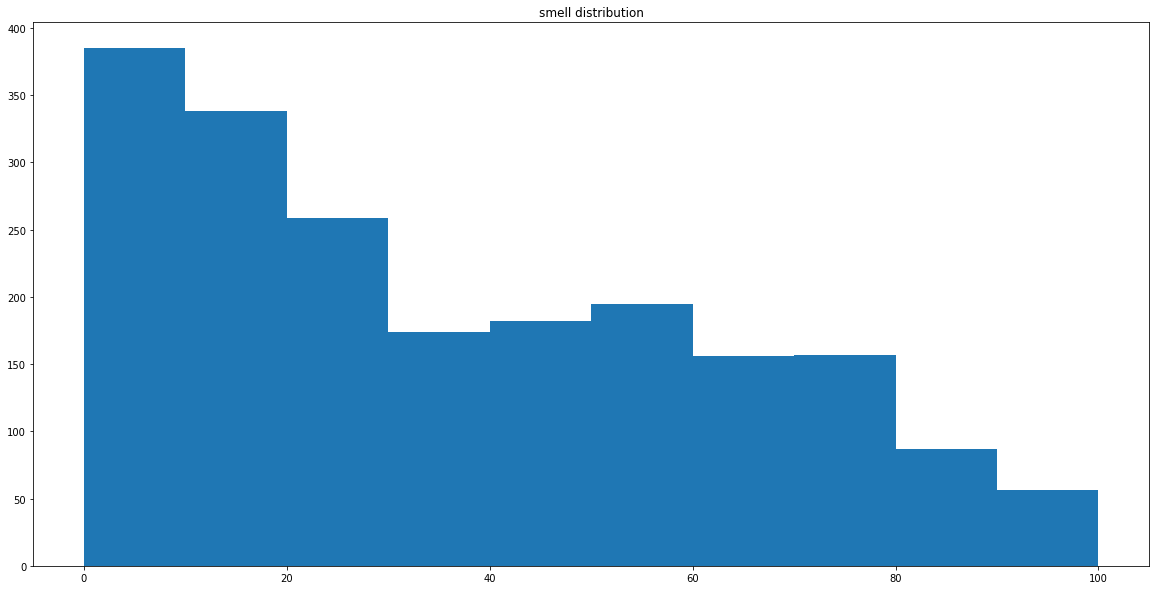

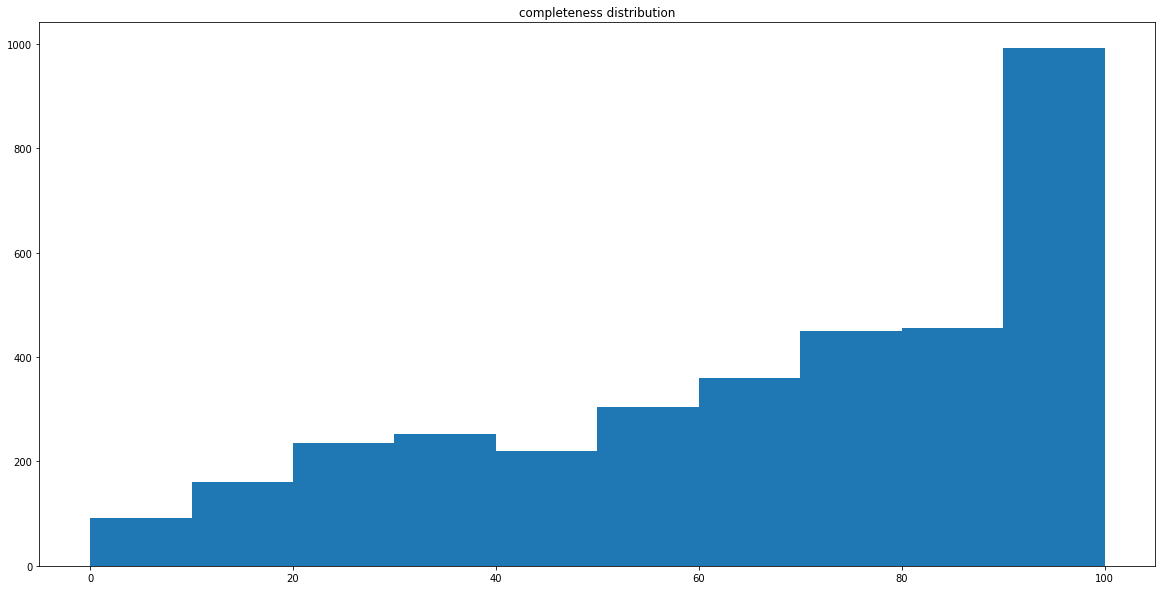

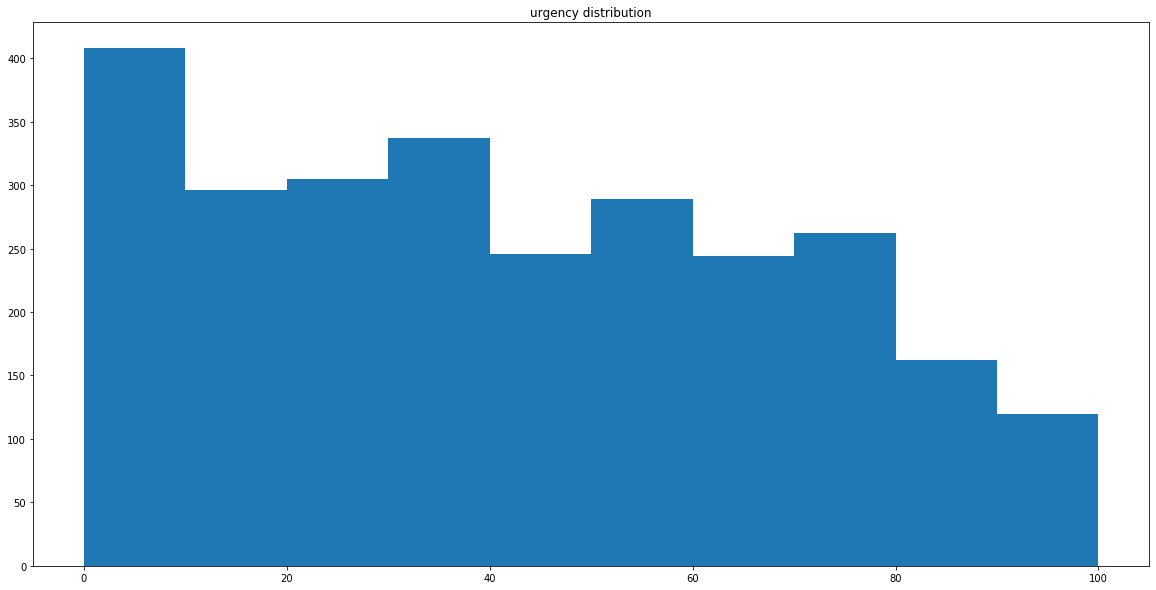

In [27]:
print('Bowel Movements:')
bm_features = ['consistency', 'difficulty', 'pain', 'smell', 'completeness', 'urgency']
for feature in bm_features:
    plot_feature_distribution(bm_df, feature)

#### Intensity

There seem to be a lot of weird string "intensity" values.

In [29]:
sym_df['intensity'].unique()

array(['25', '40', '15', '5', '20', '70', '60', '50', '10', '30', '90',
       '80', '100', '35', '55', '45', '65', '75', '95', '85', '16', '42',
       '14', 'c8072541-e336-4b50-bd2b-e5a7b0c465d4',
       '80c3dc4e-8c84-4879-a429-446ac6040744',
       'f87148b5-350a-40d9-852a-211a8031ff53',
       '5d7c7096-7d85-4467-98e0-62c2ca37bd1a',
       '5a80cb69-caed-48fb-8002-d45f52fc51c0',
       '0155eea7-1683-4ad4-84cc-5fa9f3e19270',
       'e98e388a-4c32-40a2-a5a0-dea2d1c2c819',
       '9d7fd1ea-33cf-4a73-bd6d-505aa7a0aea1',
       '4c7ec210-a2a5-4076-882e-0842378c0bda',
       '9810d9c0-da80-4648-ad99-c2c92e11c933',
       'f242dbfd-258d-477c-9fe4-d706254f7818',
       '6529e7f5-35d6-4da7-953c-f9dcd2509a62',
       'd536bd45-30c5-48ab-bd0a-fdfba78a61b9',
       '1285ace7-6cf0-4af8-9156-967a1883d24e',
       'a3b6584a-400d-4354-9bc2-94205b0a956c',
       '3f3f8720-b737-402f-9a16-70adffc53456',
       '5f7d3b52-d4cf-46f7-b433-3bf571b62e06',
       '4e437a66-cfb5-430e-85d8-b4bd51047bc8',
  

I do not know how to interpret these. I assume they are the result of errors in the data pipeline. So, I will drop them.

#### Occured At

In [80]:
print('Bowel Movements:')
display(bm_df['occurred_at'])
print('Symptoms:')
display(sym_df['occurred_at'])

Bowel Movements:


id
6162    2019-10-04 19:10:00
6161    2019-10-04 11:30:00
6131    2019-10-03 14:05:00
6103    2019-10-02 22:00:00
6102    2019-10-02 14:00:00
               ...         
3928    2019-07-21 14:15:00
3924    2019-07-21 07:30:00
3923    2019-07-20 22:00:00
3907    2019-07-20 18:10:00
3901    2019-07-20 14:00:00
Name: occurred_at, Length: 6015, dtype: object

Symptoms:


0        2019-06-20 22:00:00
1        2019-06-20 22:00:00
2        2019-06-25 18:00:00
3        2019-06-20 16:00:00
4        2019-06-20 12:00:00
                ...         
20866    2019-07-21 14:15:00
20867    2019-07-21 07:30:00
20868    2019-07-20 22:00:00
20869    2019-07-20 18:10:00
20870    2019-07-20 14:00:00
Name: occurred_at, Length: 20871, dtype: object

To explore these, I will convert this series of objects to an array of datetime64 objects.

In [81]:
bm_occurrences = pd.DatetimeIndex(pd.to_datetime(bm_df['occurred_at']))
sym_occurrences = pd.DatetimeIndex(pd.to_datetime(sym_df['occurred_at']))

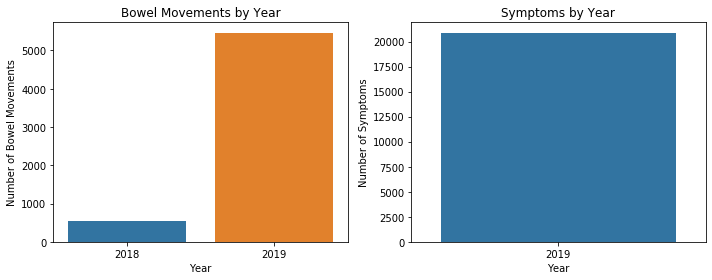

In [89]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.countplot(bm_occurrences.year)
plt.xlabel('Year')
plt.ylabel('Number of Bowel Movements')
plt.title('Bowel Movements by Year')

plt.subplot(1, 2, 2)
sns.countplot(sym_occurrences.year)
plt.xlabel('Year')
plt.ylabel('Number of Symptoms')
plt.title('Symptoms by Year')

plt.tight_layout();

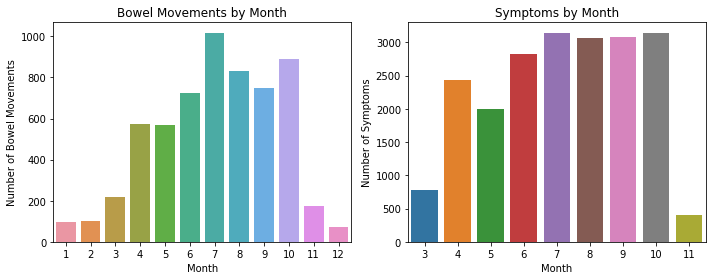

In [92]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.countplot(bm_occurrences.month)
plt.xlabel('Month')
plt.ylabel('Number of Bowel Movements')
plt.title('Bowel Movements by Month')

plt.subplot(1, 2, 2)
sns.countplot(sym_occurrences.month)
plt.xlabel('Month')
plt.ylabel('Number of Symptoms')
plt.title('Symptoms by Month')

plt.tight_layout();

This distribution should be nearly uniform, as the amount of bowel movements people experience does not vary largely between months. The graph above suggests that the data were collected primary through the spring and summer months. One possible explanation is that data collection begun in November, 2018, and the app's popularity grew afterwards.

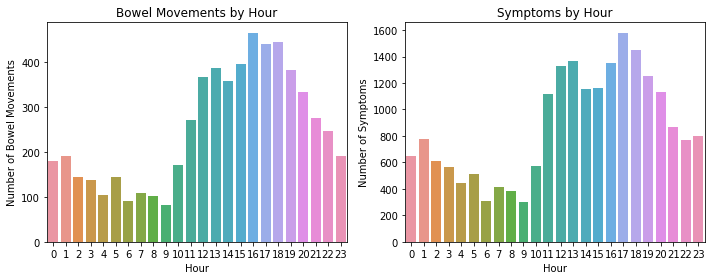

In [93]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.countplot(bm_occurrences.hour)
plt.xlabel('Hour')
plt.ylabel('Number of Bowel Movements')
plt.title('Bowel Movements by Hour')

plt.subplot(1, 2, 2)
sns.countplot(sym_occurrences.hour)
plt.xlabel('Hour')
plt.ylabel('Number of Symptoms')
plt.title('Symptoms by Hour')

plt.tight_layout();

There are a significant amount of bowel movements and symptoms logged in the middle of the night - more, in fact, than there are in the morning! This makes me skeptical of the data's validity. On the other hand, the latter part of the data suits my expectations, with a peak amount of bowel movements and symptoms logged in the middle of the afternoon.

One possible source of noise is time zones. I am unsure whether or not the data were normalized to one time zone. If not, I cannot do much with the data, for I do not know the time zone of each user.

For the reasons above as well as others, I will omit **occured_at** data from the clustering.

#### Symptom

#### Duration

<a id='preprocessing'></a>

# Preprocessing

<a id='feature_engineering'></a>

# Feature Engineering

<a id='num_clusters'></a>

# Selecting Number of Clusters

<a id='clustering'></a>

# Clustering

<a id='choose'></a>

# Choosing Best Clustering